## Setup

In [1]:
! pip install neuralogic
from neuralogic.nn import get_evaluator
from neuralogic.core import R, Template, V, Transformation, Aggregation
from neuralogic.core.settings import Settings
from neuralogic.dataset import Dataset
from neuralogic.optim import SGD
from neuralogic.utils.data import Mutagenesis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 15.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/neuralogic/core/builder/builder.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Dataset definition

In [2]:
_, dataset = Mutagenesis()

template = Template()

template.add_rules([
    (R.feature(V.A)[3,] <= R.get(atom)(V.A)) for atom in ["c", "o", "br", "i", "f", "h", "n", "cl"]
])

R.layer_1(V.X)[1,] <= (R.edge(V.Y, V.X), R.feature(V.Y)[1,])
R.layer_1(V.X)[1,] <= R.feature(V.X)[1,]
R.predict <= R.layer_1(V.X)[1,]

In [ ]:
for i in range(3):
  template += get_gnn(f"layer_{i+1}", f"layer_{i}", "bond_embed", "bond", (3, 3))
template += R.layer_0(V.X) <= R.atom_embed(V.X)
template += R.predict[1, 3] <= R.layer_3(V.X)

In [ ]:
# R-GCNs only sum over different types of relations
template = Template()

template.add_rules([
    (R.atom_embed(V.A)[3,] <= R.get(atom)(V.A)) for atom in ["c", "o", "br", "i", "f", "h", "n", "cl"]
])

template.add_rules([
    (R.bond_embed(V.B)[3,] <= R.get(bond)(V.B)) for bond in ["b_1", "b_2", "b_3", "b_4", "b_5", "b_7"]
])

template.add_rules([
    (R.bond_type(V.B) <= R.get(bond)(V.B)[3,]) for bond in ["b_1", "b_2", "b_3", "b_4", "b_5", "b_7"]
])

template +=  R.layer_1(V.X) <= (R.atom_embed(V.X)[3, 3], R.atom_embed(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B)[3, 3], R.bond_type(V.B))

template +=  R.layer_2(V.X) <= (R.layer_1(V.X)[3, 3], R.layer_1(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B)[3, 3], R.bond_type(V.B))
template +=  R.layer_3(V.X) <= (R.layer_2(V.X)[3, 3], R.layer_2(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B)[3, 3], R.bond_type(V.B))


template += R.predict[1, 3] <= R.layer_3(V.X)

def get_rgcn(layer_name: str, node_embed: str, edge_embed: str, connection: str, edge_aggregation: str, param_size: tuple):
  return (R.get(layer_name)(V.X) <= (R.get(node_embed)(V.X)[param_size],
                                     R.get(node_embed)(V.Y)[param_size],
                                     R.get(connection)(V.X, V.Y, V.B),
                                     R.get(edge_embed)(V.B),
                                     R.get(edge_aggregation)(V.B)[param_size]))

In [ ]:
### CONTROL ###
template +=  R.layer_0(V.X) <= (R.atom_embed(V.X))
template +=  R.layer_1(V.X) <= (R.layer_0(V.X)[3, 3], R.layer_0(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B)[3, 3])

template +=  R.layer_2(V.X) <= (R.layer_1(V.X)[3, 3], R.layer_1(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B)[3, 3])
template +=  R.layer_3(V.X) <= (R.layer_2(V.X)[3, 3], R.layer_2(V.Y)[3, 3], R.bond(V.X, V.Y, V.B), R.bond_embed(V.B)[3, 3])


template += R.predict[1, 3] <= R.layer_3(V.X)

{3} feature(A) :- c(A).
{3} feature(A) :- o(A).
{3} feature(A) :- br(A).
{3} feature(A) :- i(A).
{3} feature(A) :- f(A).
{3} feature(A) :- h(A).
{3} feature(A) :- n(A).
{3} feature(A) :- cl(A).


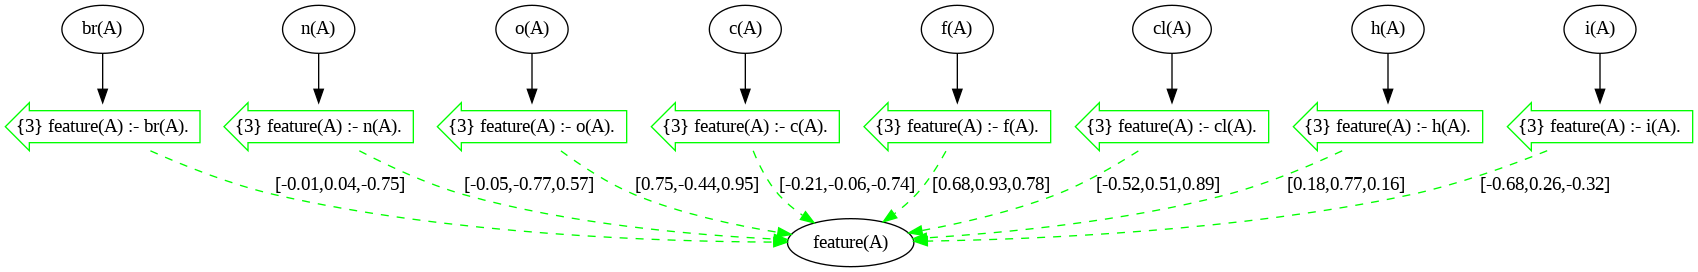

In [3]:
print(template)
template.draw()

{3} atom_embed(A) :- c(A).
{3} atom_embed(A) :- o(A).
{3} atom_embed(A) :- br(A).
{3} atom_embed(A) :- i(A).
{3} atom_embed(A) :- f(A).
{3} atom_embed(A) :- h(A).
{3} atom_embed(A) :- n(A).
{3} atom_embed(A) :- cl(A).
{3} bond_embed(B) :- b_1(B).
{3} bond_embed(B) :- b_2(B).
{3} bond_embed(B) :- b_3(B).
{3} bond_embed(B) :- b_4(B).
{3} bond_embed(B) :- b_5(B).
{3} bond_embed(B) :- b_7(B).
layer_1(X) :- {3, 3} layer_0(X), {3, 3} layer_0(Y), bond(X, Y, B), bond_embed(B).
layer_2(X) :- {3, 3} layer_1(X), {3, 3} layer_1(Y), bond(X, Y, B), bond_embed(B).
layer_3(X) :- {3, 3} layer_2(X), {3, 3} layer_2(Y), bond(X, Y, B), bond_embed(B).
layer_0(X) :- atom_embed(X).
{1, 3} predict :- layer_3(X).


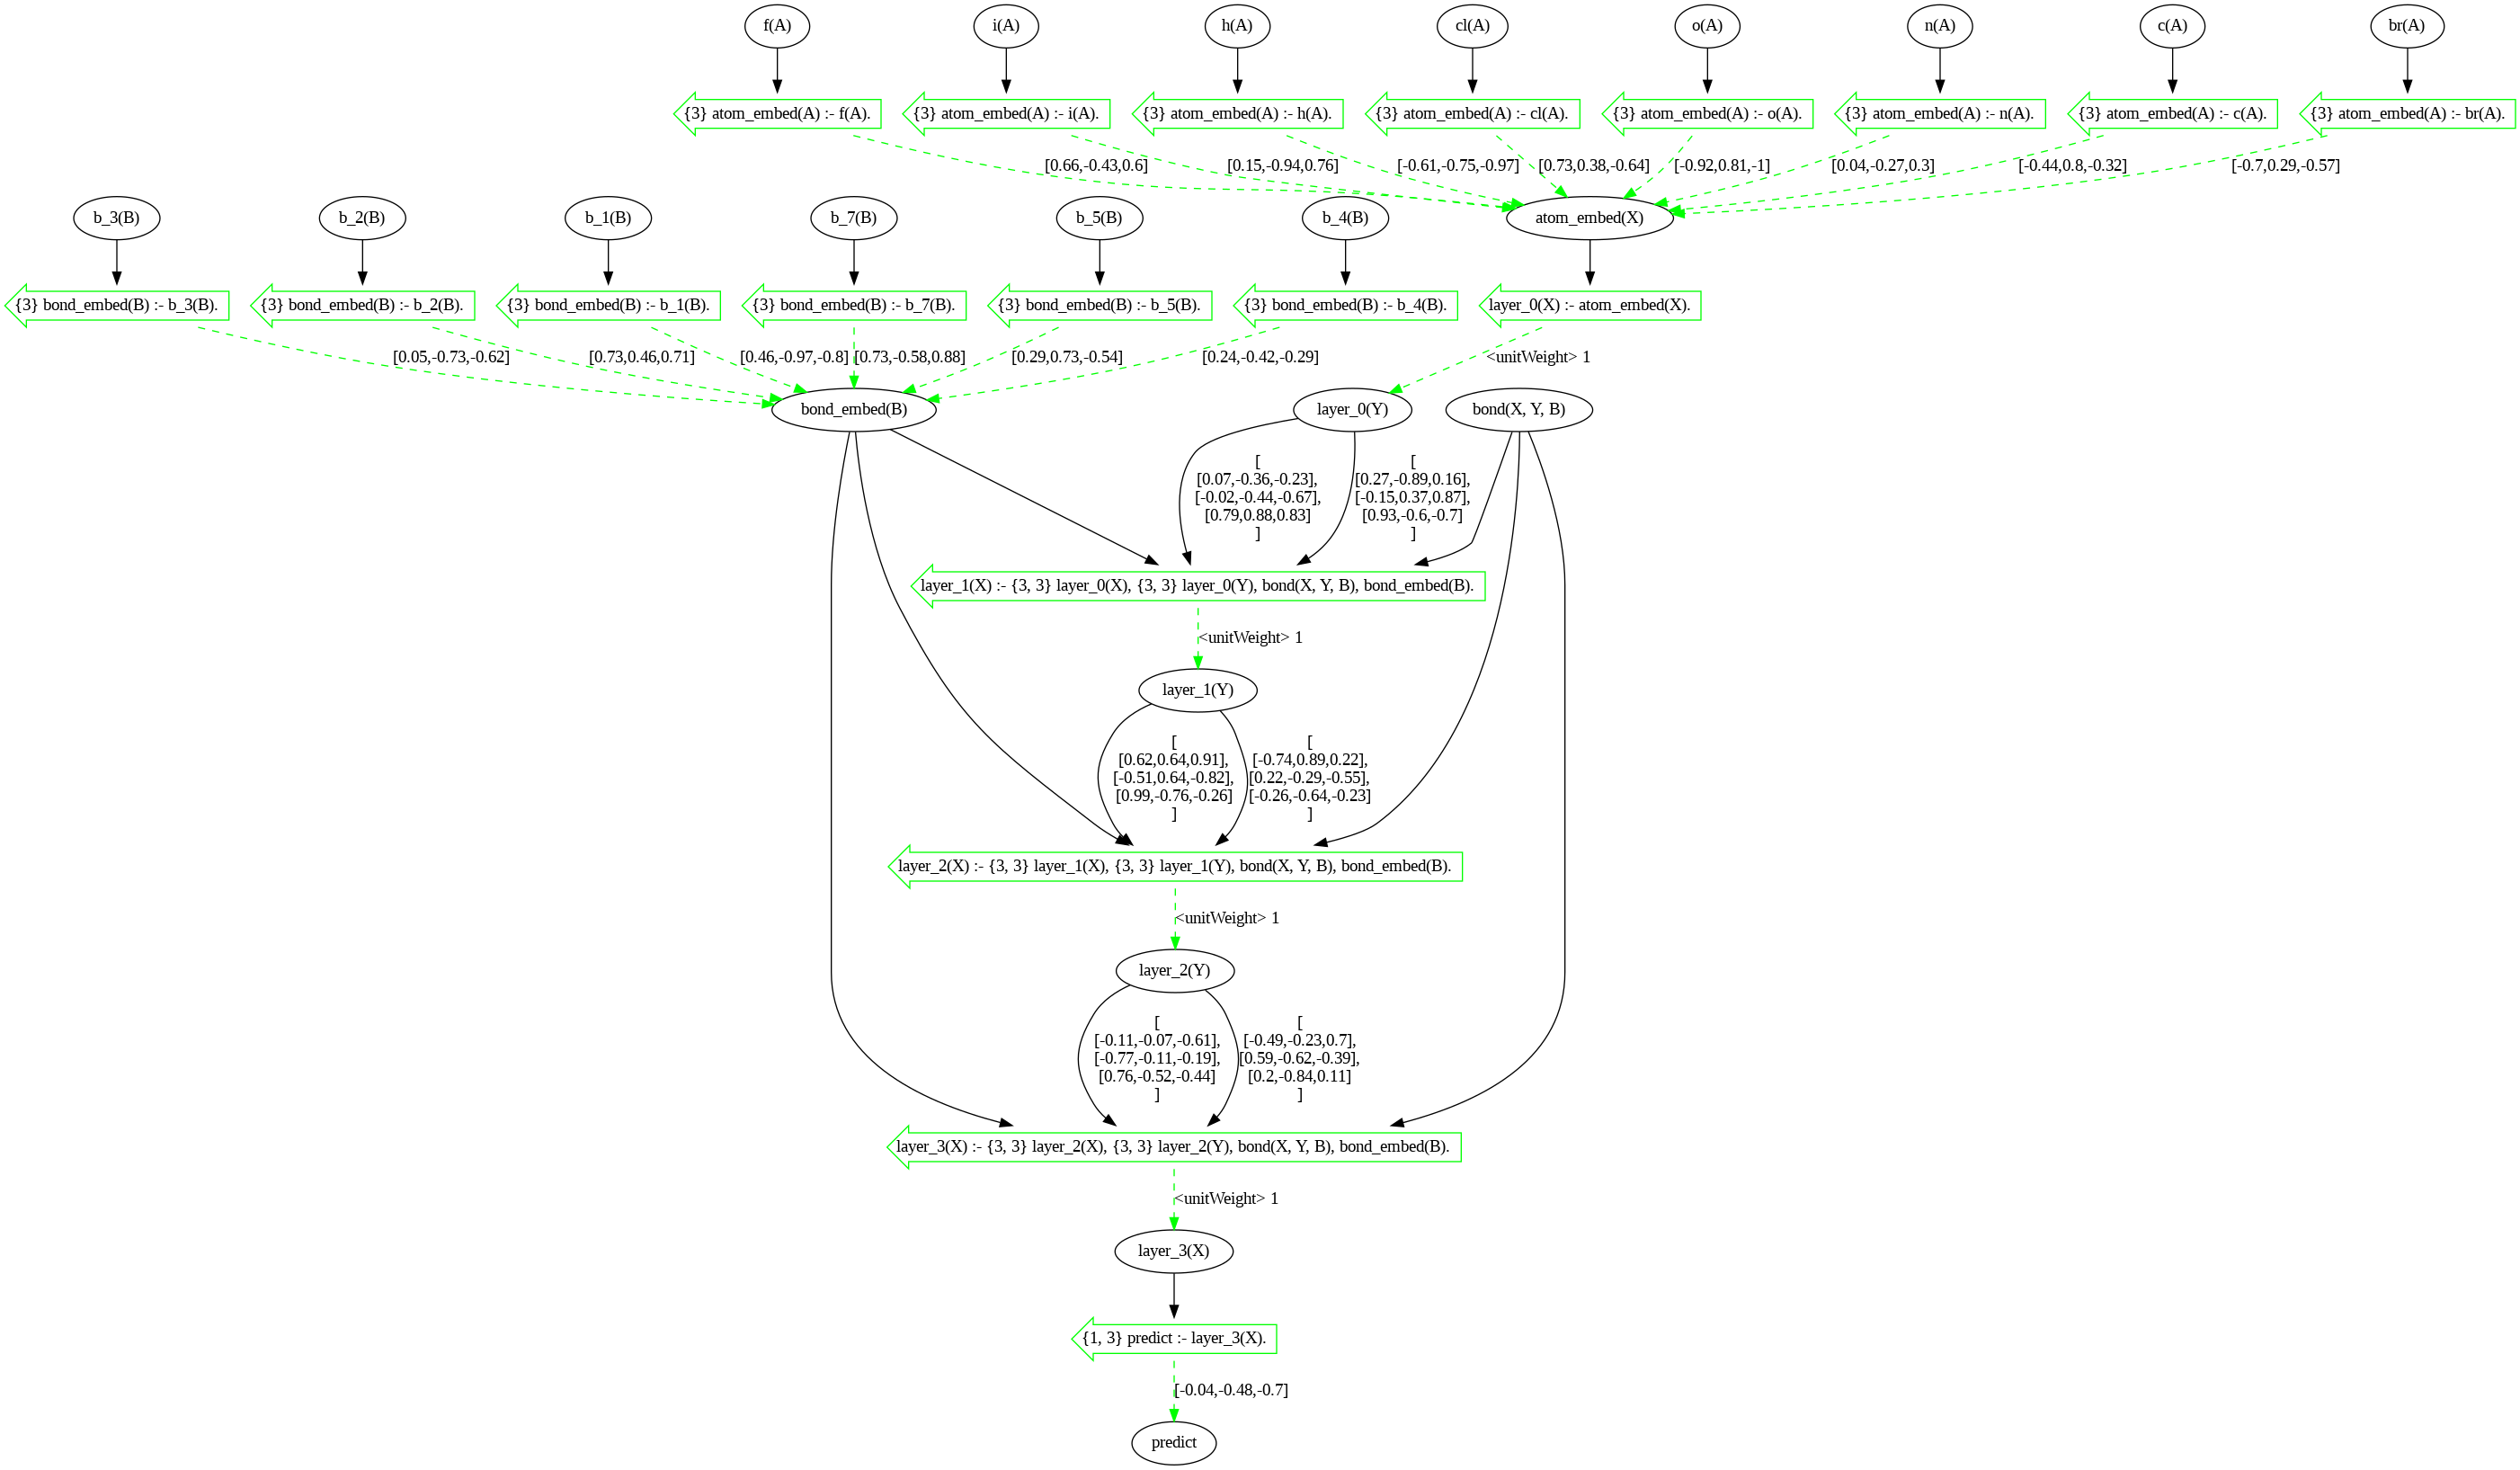

In [ ]:
print(template)
template.draw()

## Training

In [ ]:
from neuralogic.core import Settings
from neuralogic.nn.loss import MSE
from neuralogic.nn import get_evaluator
from neuralogic.optim import Adam
import random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_test_cycle(template, dataset, lr=0.001, epochs=100, split=0.75):
  settings = Settings(optimizer=Adam(lr=lr), epochs=epochs, error_function=MSE())
  evaluator = get_evaluator(template, settings)

  built_dataset = evaluator.build_dataset(dataset)
  dataset_len = len(built_dataset.samples)

  train_size = int(dataset_len*split)

  idx = random.sample(list(range(dataset_len)), train_size)
  rest = list(set(range(dataset_len)) - set(idx))
  train_dataset = np.array(built_dataset.samples)[idx]
  test_dataset = np.array(built_dataset.samples)[rest]
  average_losses = []

  for current_total_loss, number_of_samples in evaluator.train(train_dataset):
      clear_output(wait=True)
      plt.ylabel("Loss")
      plt.xlabel("Epoch")

      plt.xlim(0, settings.epochs)
      
      train_loss = current_total_loss/number_of_samples
      print(train_loss)

      average_losses.append(train_loss)
      
      plt.plot(average_losses, label="Average loss")

      plt.legend()
      plt.pause(0.001)
      plt.show()

  loss = []
  for sample, y_hat in zip(test_dataset, evaluator.test(test_dataset, generator=False)):
      loss.append(round(y_hat) != sample.java_sample.target.value)

  test_loss = sum(loss) / len(test_dataset)

  return train_loss, test_loss, evaluator


0.12186459269275453


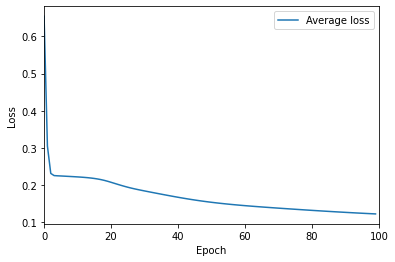

0.2127659574468085

In [ ]:
test_losses = []
for i in range(1):
  print("Training and testing model #{}".format(i))
  train_loss, test_loss, eval = train_test_cycle(template, dataset)
  test_losses.append(test_loss)

np.average(test_losses)